In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models


In [ ]:
# Basic Residual Block
# 입력 (identity)
#    ↓
# Conv → BN → ReLU → Conv → BN (F(x))
#    ↓
# Add: F(x) + identity
#    ↓
# ReLU

def basic_block(x, filters, stride=1, downsample=None, block_name="block", use_skip=True):
    identity = x

    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False, name=f"{block_name}_conv1")(x)
    x = layers.BatchNormalization(name=f"{block_name}_bn1")(x)
    x = layers.ReLU(name=f"{block_name}_relu1")(x)

    x = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False, name=f"{block_name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{block_name}_bn2")(x)

    # skip connection 조건부 적용
    if use_skip:
        if downsample is not None:
            identity = downsample
        x = layers.Add(name=f"{block_name}_add")([x, identity])

    x = layers.ReLU(name=f"{block_name}_relu2")(x)
    return x

In [ ]:
# BottleneckBlock (ResNet-50용)
# Input (x)
#    │
#  1×1 Conv → BN → ReLU
#    ↓
#  3×3 Conv → BN → ReLU
#    ↓
#  1×1 Con (↑채널 확장, filters × 4) v → BN ---> Bottleneck, 여기에는 ReLU 없음
#    ↓
#  BatchNorm + Add(x) + ReLU  ← 여기서 비선형성 적용!
#    ↓
# Output


def bottleneck_block(x, filters, stride=1, downsample=None, block_name="block", use_skip=True):
    identity = x
    expansion = 4
    out_filters = filters * expansion

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False, name=f"{block_name}_conv1")(x)
    x = layers.BatchNormalization(name=f"{block_name}_bn1")(x)
    x = layers.ReLU(name=f"{block_name}_relu1")(x)

    x = layers.Conv2D(filters, 3, strides=stride, padding='same', use_bias=False, name=f"{block_name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{block_name}_bn2")(x)
    x = layers.ReLU(name=f"{block_name}_relu2")(x)

    x = layers.Conv2D(out_filters, 1, strides=1, use_bias=False, name=f"{block_name}_conv3")(x)
    x = layers.BatchNormalization(name=f"{block_name}_bn3")(x)

    # skip connection 조건부 적용
    if use_skip:
        if downsample is not None:
            identity = downsample
        x = layers.Add(name=f"{block_name}_add")([x, identity])

    x = layers.ReLU(name=f"{block_name}_relu3")(x)
    return x


In [ ]:
# ResNet architecture
# Conv1 (1개) : 초기 이미지 입력을 받는 블록
# Conv2_x (3 block × 2 or 3) = 6 Conv or 9 Conv
# Conv3_x (4 block × 2 or 3) = 8 Conv or 12 Conv
# Conv4_x (6 block × 2 or 3) = 12 Conv or 18 Conv
# Conv5_x (3 block × 2 or 3) = 6 Conv or 9 Conv
# GlobalAveragePooling2D
# FC (Dense with softmax) (1개)

# 블록	   반복 	채널(filters) 	stride
# Conv2_x	 3	   64	              1
# Conv3_x	 4	   128	            2 ⬅️ 해상도 줄임
# Conv4_x	 6	   256	            2
# Conv5_x	 3	   512	            2



def build_resnet(input_shape=(32, 32, 3), num_classes=10, is_50=False, use_skip=True):
    block = bottleneck_block if is_50 else basic_block
    expansion = 4 if is_50 else 1

    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False, name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name='pool1')(x)

    def make_layer(x, filters, blocks, stride, name):
        downsample = None
        out_filters = filters * expansion
        if stride != 1 or x.shape[-1] != out_filters:
            downsample = layers.Conv2D(out_filters, 1, strides=stride, use_bias=False, name=f"{name}_down_conv")(x)
            downsample = layers.BatchNormalization(name=f"{name}_down_bn")(downsample)

        x = block(x, filters, stride=stride, downsample=downsample, block_name=f"{name}_block1", use_skip=use_skip)
        for i in range(1, blocks):
            x = block(x, filters, stride=1, downsample=None, block_name=f"{name}_block{i+1}", use_skip=use_skip)
        return x

    x = make_layer(x,  64, 3, stride=1, name='layer1')
    x = make_layer(x, 128, 4, stride=2, name='layer2')
    x = make_layer(x, 256, 6, stride=2, name='layer3')
    x = make_layer(x, 512, 3, stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model_name = f"{'ResNet' if use_skip else 'Plain'}-{50 if is_50 else 34}"
    model = models.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [ ]:
resnet34 = build_resnet(input_shape=(160, 160, 3), is_50=False, use_skip=True)
plain34 = build_resnet(input_shape=(160, 160, 3), is_50=False, use_skip=False)
resnet50 = build_resnet(input_shape=(160, 160, 3), is_50=True, use_skip=True)
plain50 = build_resnet(input_shape=(160, 160, 3), is_50=True, use_skip=False)

resnet34.summary()
plain34.summary()
resnet50.summary()
plain50.summary()

Model: "ResNet-34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 80, 80,    │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 80, 80,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (ReLU)        │ (None, 80, 80,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 40, 40,    │          0 │ relu1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv1 │ (None, 40, 40,    │     36,864 │ pool1[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn1   │ (None, 40, 40,    │        256 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_relu1 │ (None, 40, 40,    │          0 │ layer1_block1_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv2 │ (None, 40, 40,    │     36,864 │ layer1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn2   │ (None, 40, 40,    │        256 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_add   │ (None, 40, 40,    │          0 │ layer1_block1_bn… │
│ (Add)               │ 64)               │            │ pool1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_relu2 │ (None, 40, 40,    │          0 │ layer1_block1_ad… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_conv1 │ (None, 40, 40,    │     36,864 │ layer1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_bn1   │ (None, 40, 40,    │        256 │ layer1_block2_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_relu1 │ (None, 40, 40,    │          0 │ layer1_block2_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_conv2 │ (None, 40, 40,    │     36,864 │ layer1_block2_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block2_bn2   │ (None, 40, 40,    │        256 │ layer1_block2_co

 Total params: 21,306,826 (81.28 MB)

 Trainable params: 21,289,802 (81.21 MB)

 Non-trainable params: 17,024 (66.50 KB)

Model: "Plain-34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 80, 80, 64)     │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 80, 80, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_conv1 (Conv2D)    │ (None, 40, 40, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_bn1               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_relu1 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_conv2 (Conv2D)    │ (None, 40, 40, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_bn2               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_relu2 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_conv1 (Conv2D)    │ (None, 40, 40, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_bn1               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_relu1 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_conv2 (Conv2D)    │ (None, 40, 40, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_bn2               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_relu2 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block3_conv1 (Conv2D)    │ (None, 40, 40, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block3_bn1               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block3_relu1 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block3_conv2 (Conv2D)    │ (None, 40, 40, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block3_bn2               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 21,131,210 (80.61 MB)

 Trainable params: 21,115,978 (80.55 MB)

 Non-trainable params: 15,232 (59.50 KB)

Model: "ResNet-50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 80, 80,    │      9,408 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 80, 80,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1 (ReLU)        │ (None, 80, 80,    │          0 │ bn1[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 40, 40,    │          0 │ relu1[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv1 │ (None, 40, 40,    │      4,096 │ pool1[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn1   │ (None, 40, 40,    │        256 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_relu1 │ (None, 40, 40,    │          0 │ layer1_block1_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv2 │ (None, 40, 40,    │     36,864 │ layer1_block1_re… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn2   │ (None, 40, 40,    │        256 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_relu2 │ (None, 40, 40,    │          0 │ layer1_block1_bn… │
│ (ReLU)              │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_conv3 │ (None, 40, 40,    │     16,384 │ layer1_block1_re… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_down_conv    │ (None, 40, 40,    │     16,384 │ pool1[0][0]       │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_bn3   │ (None, 40, 40,    │      1,024 │ layer1_block1_co… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_down_bn      │ (None, 40, 40,    │      1,024 │ layer1_down_conv… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_add   │ (None, 40, 40,    │          0 │ layer1_block1_bn… │
│ (Add)               │ 256)              │            │ layer1_down_bn[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer1_block1_relu3 │ (None, 40, 40,    │          0 │ layer1_block1_ad

 Total params: 23,581,642 (89.96 MB)

 Trainable params: 23,528,522 (89.75 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "Plain-50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 80, 80, 64)     │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 80, 80, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_conv1 (Conv2D)    │ (None, 40, 40, 64)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_bn1               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_relu1 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_conv2 (Conv2D)    │ (None, 40, 40, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_bn2               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_relu2 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_conv3 (Conv2D)    │ (None, 40, 40, 256)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_bn3               │ (None, 40, 40, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block1_relu3 (ReLU)      │ (None, 40, 40, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_conv1 (Conv2D)    │ (None, 40, 40, 64)     │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_bn1               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_relu1 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_conv2 (Conv2D)    │ (None, 40, 40, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_bn2               │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_relu2 (ReLU)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_conv3 (Conv2D)    │ (None, 40, 40, 256)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer1_block2_bn3               │ (None, 40, 40, 256)    │         1,024 │
│ (BatchNormalization)            │                        │             

 Total params: 20,797,386 (79.34 MB)

 Trainable params: 20,751,946 (79.16 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
import tensorflow_datasets as tfds

# 데이터 전처리 함수
IMG_SIZE = 160
BATCH_SIZE = 32

def preprocess(example):
    image = tf.image.resize(example['image'], (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0  # 정규화
    label = example['label']
    return image, label

# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # 학습/검증 나누기
    as_supervised=False,
    with_info=True
)

# 전처리 및 배치 구성
ds_train = ds_train.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.3CHXVC_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
models_dict = {
    "ResNet-34": resnet34,
    "ResNet-50": resnet50,
    "Plain-34": plain34,
    "Plain-50": plain50,
}

for name, model in models_dict.items():
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print(f"{name} compiled ✅")


ResNet-34 compiled ✅
ResNet-50 compiled ✅
Plain-34 compiled ✅
Plain-50 compiled ✅


In [ ]:
# 학습
resnet34_history = resnet34.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5
)

resnet50_history = resnet50.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5
)

plain34_history = plain34.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5
)

plain50_history =plain50.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 127s 162ms/step - accuracy: 0.5732 - loss: 0.9141 - val_accuracy: 0.6305 - val_loss: 0.7399
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - accuracy: 0.7261 - loss: 0.5452 - val_accuracy: 0.5606 - val_loss: 0.7250
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - accuracy: 0.8030 - loss: 0.4239 - val_accuracy: 0.5613 - val_loss: 0.9365
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 84s 143ms/step - accuracy: 0.8455 - loss: 0.3528 - val_accuracy: 0.8020 - val_loss: 0.5233
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 85s 143ms/step - accuracy: 0.8773 - loss: 0.2889 - val_accuracy: 0.8422 - val_loss: 0.3356
Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 191s 250ms/step - accuracy: 0.5851 - loss: 0.9023 - val_accuracy: 0.4946 - val_loss: 2.0329
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 153s 198ms/step - accuracy: 0.6444 - loss: 0.6434 - val_accuracy: 0.6677 - val_loss: 0.6234
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 117s 198ms/step - accuracy: 0.7016 - loss: 0.576

<ipython-input-14-8c2c2f640fd8>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('tab10', len(labels))


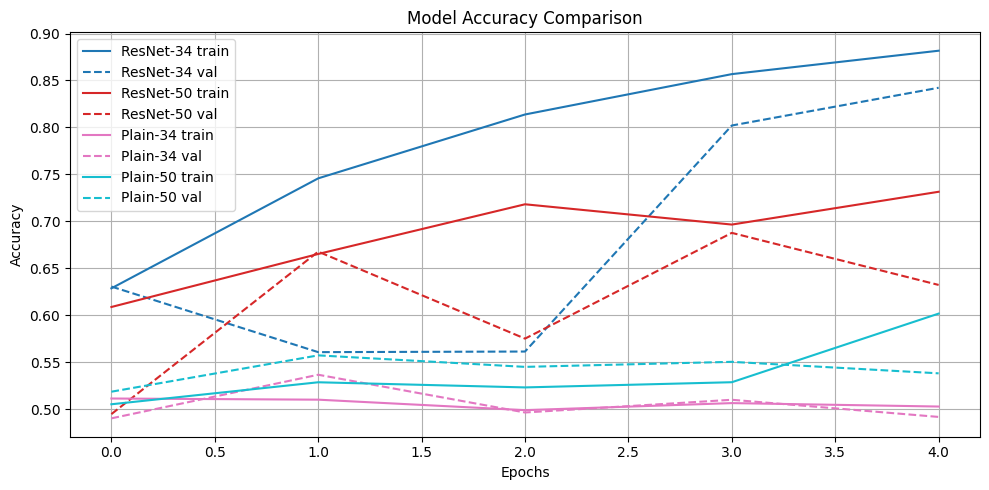

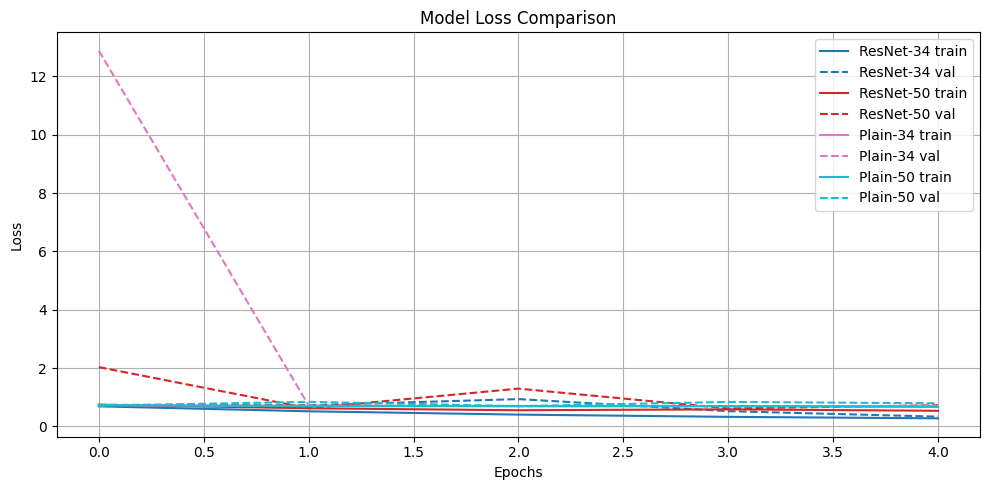

In [ ]:
import matplotlib.pyplot as plt

def plot_all_histories(histories, labels, metric='accuracy'):
    """
    histories: list of history objects
    labels: list of model names
    metric: 'accuracy' or 'loss'
    """
    plt.figure(figsize=(10, 5))

    # 고정 색상 팔레트
    color_map = plt.cm.get_cmap('tab10', len(labels))

    for i, (history, label) in enumerate(zip(histories, labels)):
        color = color_map(i)
        plt.plot(history.history[metric], label=f'{label} train', color=color)
        plt.plot(history.history[f'val_{metric}'], label=f'{label} val', color=color, linestyle='--')

    plt.title(f'Model {metric.capitalize()} Comparison')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_all_histories(
    histories=[resnet34_history, resnet50_history, plain34_history, plain50_history],
    labels=['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'],
    metric='accuracy'
)

plot_all_histories(
    histories=[resnet34_history, resnet50_history, plain34_history, plain50_history],
    labels=['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'],
    metric='loss'
)


In [ ]:
import pandas as pd

def summarize_histories(histories, labels):
    results = []
    for history, label in zip(histories, labels):
        val_loss = history.history['val_loss'][-1]        # 마지막 epoch의 val loss
        val_accuracy = history.history['val_accuracy'][-1]  # 마지막 epoch의 val acc
        results.append({'Model': label, 'Val Loss': round(val_loss, 4), 'Val Accuracy': round(val_accuracy, 4)})

    df = pd.DataFrame(results)
    return df

# 예시 사용
model_histories = [resnet34_history, resnet50_history, plain34_history, plain50_history]
model_labels = ['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50']

df_result = summarize_histories(model_histories, model_labels)
print(df_result)


       Model  Val Loss  Val Accuracy
0  ResNet-34    0.3356        0.8422
1  ResNet-50    0.7275        0.6322
2   Plain-34    0.7008        0.4916
3   Plain-50    0.7925        0.5380
